https://www.sec.gov/Archives/edgar/data/19617/000161577420003827/s124211_424b2.htm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.sparse import diags
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
inv = np.linalg.inv

 ## Forward Difference
\begin{align}
\ \frac{\nu_n^{m+1} - \nu_n^{m}}{\Delta t} - 0.5(r-d)n(\nu_{n+1}^{m} - \nu_{n-1}^m) - 0.5\sigma^2n^2(\nu_{n+1}^m-2\nu_n^m+\nu_{n-1}^m)+r\nu_n^m = 0        \\
\ \\
\end{align}
 ## Backward Difference
\begin{align}
\ \frac{\nu_n^{m+1} - \nu_n^{m}}{\Delta t} - 0.5(r-d)n(\nu_{n+1}^{m+1} - \nu_{n-1}^{m+1}) - 0.5\sigma^2n^2(\nu_{n+1}^{m+1}-2\nu_n^{m+1}+\nu_{n-1}^{m+1})+r\nu_n^{m+1} = 0 \\
\end{align}

 ## Average : 
\begin{align}
\ 0 = \nu_n^{m+1} - \nu_n^{m} - \frac{\Delta t}{4} (r-d) n (\nu_{n+1}^{m+1}-\nu_{n-1}^{m+1}+\nu_{n+1}^{m}-\nu_{n-1}^{m}) + \frac{\Delta t}{2} r(\nu_{n}^{m+1}+\nu_n^m) - \frac{\Delta t}{4} \sigma^2 n^2 ( \nu_{n+1}^{m+1}-2\nu_n^{m+1}+\nu_{n-1}^{m+1} + \nu_{n+1}^{m} - 2\nu_n^m + \nu_{n-1}^m) \\
\end{align}

 ## Then,
\begin{align}
\ \frac{1}{4} ( \sigma^2 n^2 -(r-d)n ) \nu_{n-1}^{m} + (-\frac{1}{\Delta t}- \frac{1}{2} r - \frac{1}{2}\sigma^2 n^2)\nu_n^m + \frac{1}{4} ((r-d)n + \sigma^2 n^2 )\nu_{n+1}^m \\ =  -\frac{1}{4} (\sigma^2 n^2 -(r-d)n)\nu_{n-1}^{m+1} - (\frac{1}{\Delta t}- \frac{1}{2} r - \frac{1}{2}\sigma^2 n^2)\nu_n^{m+1} - \frac{1}{4}((r-d)n+\sigma^2 n^2 ) \nu_{n+1}^{m+1} \\
\ \\
\end{align}

## Coefficients
\begin{align}
\ \\ 
\ \kappa = \frac{1}{2}(r+\sigma^2 n^2) \\
\ \\ 
\ a_n = \frac{1}{4}(\sigma^2 n^2 - (r-d)n) \\
\ b_n = (-\kappa_n - \frac{1}{dt} )\\
\ c_n = \frac{1}{4}(\sigma^2 n^2 - (r-d)n) \\
\ d_n = -a_n \times V_{n-1}^{m+1} - (b_n + \frac{2}{\Delta t})V_{n}^{m+1} -c_n \times V_{n+1}^{m+1} \\
\ a_n V_{n-1}^{m} + b_n V_{n}^{m} + c_n V_{n+1}^{m} = -a_n V_{n-1}^{m+1} - (b_n + \frac{2}{\Delta t} ) V_{n}^{m+1} - c_n V_{n+1}^{m+1}\\
\end{align}
## Smoothing boundary at t
\begin{align}
\ V_{-1}^{m+1} = 2V_{0}^{m+1} - V_{1}^{m+1}  \\ \ V_{N+1}^{m+1}= 2V_N^{m+1}-V_{N-1}^{m+1} \\ \ d_0^{m+1} = (-2 \bullet a_0-b_0-\frac{2}{dt}) V_0^{m+1} + (a_0-c_0) V_{1}^{m+1} \\
\ d_N^{m+1} = (c_N-a_N)V_{N-1}^{m+1} + (-2\bullet c_N-b_N-\frac{2}{dt})V_{N}^{m+1}\\
\end{align}

$$\begin{bmatrix} b_0 + 2a_0 & c_0-a_0 & 0 & 0& ... & 0& 0 & 0\\ a_1 & b_1 & c_1& 0& ...& 0 & 0& 0 \\ 0 & a_2 & b_2& c_2& ...& 0 & 0& 0\\ 0 & 0 & a_3& b_3& ...& 0& 0& 0\\ ... & ... & ...& ...& ...& 0& 0& 0\\ 0 & 0 & 0& 0& ...& a_{N-1} & b_{N-1}& c_{N-1}\\ 0 & 0 & 0& 0& 0& 0& a_{N}-c_{N}& b_{N}+2c_{N} \end{bmatrix} \begin{bmatrix} v_0^{m} \\ v_1^{m} \\ v_2^{m}\\ ...\\ ...\\ v_{N-1}^{m}\\ v_{N}^{m}\end{bmatrix} = \begin{bmatrix} d_0^{m+1} \\ d_1^{m+1} \\ d_2^{m+1}\\ ...\\ ...\\ d_{N-1}^{m+1}\\ d_{N}^{m+1}\end{bmatrix}$$ 

In [2]:
#################################
#######  Basic Settings   #######
#################################
DF = pd.DataFrame([0.991958467,0.990731684],                   
                  index = [datetime.datetime(2021,6,16),datetime.datetime(2021,9,15)],
                  columns=['DF'])
DF_ = np.exp(np.log(DF.resample('D').last()).interpolate(method = 'linear'))
today = datetime.datetime(2020,3,23)
Mat = datetime.datetime(2021,6,28)
Review_dates = list(((pd.Series(pd.date_range(today, Mat , freq = 'MS')) +datetime.timedelta(days = 22))[2::3]))
Coupon_date = list(pd.Series(Review_dates) + datetime.timedelta(days = 1))[:-1] + [pd.Timestamp(Mat)]

 ## Variables

In [3]:
r = -np.log(DF_.loc[Mat][0]) / ((Mat-today).days/365)
Div_S =  0.047335 * 4/5 # There are 4 times dividend drop before maturity May, Aug, Nov, Feb
S = 91.9
K = 91.9
B = S * 0.7
sigma_KI = 0.45116 ## 100% IV 0.45116
sigma_NKI = 0.55591 ## 70% IV 0.55591
F = 1000
compound = 1/4

In [4]:
S_max_times=3
S_min_times=0
F=1000
c_rate = 0.13
compound = 1/4
N=300
dt = 1/252
ret_dS = False

In [5]:
def Security_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,                   
                   Coupon_date,S_max_times=3,S_min_times=0,F=1000,
                   c_rate = 0.13,compound = 1/4,N=300, dt = 1/365,ret_dS = False) :
    #######################
    #### Basic Settings ###
    #########################################################################################################
    
    Day_node = pd.date_range(today, Mat,freq = 'D')    
    S_max, S_min = S * S_max_times, S* S_min_times
    dS = (S_max - S_min)/N
    Coupon = F * c_rate * compound
    n = np.arange(0,N+1)

    NKI_value_mat = pd.DataFrame(np.zeros((N+1,len(Day_node))) , index = (n*dS).round(4), columns=Day_node)
    S_mat = (n * dS).reshape(-1,1) * np.ones(NKI_value_mat.shape)
    KI_value_mat= NKI_value_mat.copy()
    stock_return = S_mat[:,-1]/S -1
    KI_value_mat[Day_node[-1]] = ((S_mat[:,-1]>=K )* (F + Coupon) +
                                  (S_mat[:,-1]<K )*(S_mat[:,-1]>B) *(F +stock_return*F+Coupon) +
                                 (S_mat[:,-1]<B) * (F+stock_return*F))
    NKI_value_mat[Day_node[-1]] = ((S_mat[:,-1]>=B )* (F + Coupon) +                                                
                                   (S_mat[:,-1]<B ) *(F +stock_return*F))                                           
    ########################################################################################################
    ### a(n), b(n), c(n) Settings at Knuck In Case ###
    ##################################################
    sigma = sigma_KI
    an = 0.25 * (sigma**2 * n**2 - (r-Div_S) * n)
    bn = -0.5 * sigma**2 * n**2 - 0.5 * r - 1/dt
    cn = 0.25 * (sigma**2 * n**2 + (r-Div_S) * n)
    a0 , b0 , c0 = an[0], bn[0], cn[0]
    aN , bN, cN = an[-1],bn[-1],cn[-1]
    bn[0] = 2*a0 + b0
    cn[0] = c0-a0
    bn[-1] = bN +2*cN
    an[-1] = aN - cN    
    k = np.array([an[1:], bn, cn[:-1]])
    offset = [-1,0,1]
    diag = diags(k,offset).toarray()
    inv_diag = inv(diag)                      ### Inverse Tridiagonal Matrix
                                              
    #############################################
    ###   Pricing Notes at Knuck In Case   ######
    ##########################################################################################          
    for i in np.arange(len(Day_node)-1,0, -1) : 

        V = np.array(KI_value_mat[Day_node[i]])
        d0 = (-2*a0-b0-2/dt) * V[0] + (a0-c0) * V[1]
        d_max = (cN-aN)*V[-2] + (-2*cN-bN-2/dt)*V[-1]
        dn = -an[1:-1] * V[0:-2] - (bn[1:-1] + 2/dt) * V[1:-1] - cn[1:-1] * V[2:]
        d = np.concatenate([[d0],dn,[d_max]]).reshape(-1,1)
        KI_value_mat[Day_node[i-1]] =  inv_diag.dot(d).reshape(-1)
        if Day_node[i-1] in Coupon_date :
            KI_value_mat[Day_node[i-1]] =  ((S_mat[:,-1] >= K) * (F+Coupon) +
                                            (S_mat[:,-1] >= B)*(S_mat[:,-1] < K) * (KI_value_mat[Day_node[i-1]] + Coupon) +
                                            (S_mat[:,-1] < B)*KI_value_mat[Day_node[i-1]])
    len_Barrier_below = (S_mat[:,-1]<=B).sum()
    
    #########################################################################################
    ### Overwrites the KI Price below KI Barrier and Set The NKI Tridiagonal###
    ##############################################################################              
    NKI_value_mat.iloc[:len_Barrier_below] = KI_value_mat.iloc[:len_Barrier_below]    
    
    sigma = sigma_NKI
    an = 0.25 * (sigma**2 * n**2 - (r-Div_S) * n)
    bn = -0.5 * sigma**2 * n**2 - 0.5 * r - 1/dt
    cn = 0.25 * (sigma**2 * n**2 + (r-Div_S) * n)
    a0 , b0 , c0 = an[0], bn[0], cn[0]
    aN , bN, cN = an[-1],bn[-1],cn[-1]
    bn[0] = 2*a0 + b0
    cn[0] = c0-a0
    bn[-1] = bN +2*cN
    an[-1] = aN - cN
    
    k = np.array([an[1:], bn, cn[:-1]])
    offset = [-1,0,1]
    diag = diags(k,offset).toarray()
    inv_diag = inv(diag)    

    #############################################################################
    ### Pricing Notes at Not Knuck In Case ###
    ##########################################          
    
    
    for i in np.arange(len(Day_node)-1,0, -1) : 

        V = np.array(NKI_value_mat[Day_node[i]])
        d0 = (-2*a0-b0-2/dt) * V[0] + (a0-c0) * V[1]
        d_max = (cN-aN)*V[-2] + (-2*cN-bN-2/dt)*V[-1]
        dn = -an[1:-1] * V[0:-2] - (bn[1:-1] + 2/dt) * V[1:-1] - cn[1:-1] * V[2:]
        d = np.concatenate([[d0],dn,[d_max]]).reshape(-1,1)
        NKI_value_mat[Day_node[i-1]].iloc[len_Barrier_below:] =  inv_diag.dot(d).reshape(-1)[len_Barrier_below:]
        if Day_node[i-1] in Coupon_date :
            NKI_value_mat[Day_node[i-1]] =  ((S_mat[:,-1] >= K) * (F+Coupon) +
                                            (S_mat[:,-1] >= B)*(S_mat[:,-1] < K) * (NKI_value_mat[Day_node[i-1]] + Coupon) +
                                            (S_mat[:,-1] < B)*NKI_value_mat[Day_node[i-1]])
    if ret_dS == False : 
        return NKI_value_mat
    else : 
        return NKI_value_mat, dS

In [6]:
Price = Security_Price(S,K,B,sigma_KI, sigma_NKI,r,Div_S,today,Mat,
                       Coupon_date,S_max_times=3,S_min_times=0,F=1000,
                       c_rate = 0.13,compound = 1/4,N=300)

In [7]:
def Current_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                  Coupon_date,S_max_times=3,S_min_times=0,F=1000,                  
                  c_rate = 0.13,compound = 1/4,N=300 ,dt = 1/365) :
    
    Price, dS = Security_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                               Coupon_date,S_max_times,S_min_times,F,
                               c_rate,compound,N, ret_dS = True)    
    
    ######################################################
    ### P is Price at Today , Lamb is Lambda (B-S')/dS ###
    ######################################################
    if S in Price.index :
        ind = list(Price.index).index(S)
        P = Price[today].iloc[ind]    
    else : 
        ind = ((S - np.array(Price.index))>=0).sum()
        x1 = Price.index[ind-1]
        x2 = Price.index[ind]
        y1 = Price[today].iloc[ind-1]
        y2 = Price[today].iloc[ind]
        slope = (y2-y1)/(x2-x1)
        P = slope*(S-x1)+y1    

    ind_ = ((B-np.array(Price.index))>=0).sum()
    lamb = (B - np.array(Price.index)[ind_-1])/dS 
    return P, np.round(lamb,1)

In [11]:
def plotting_error(S_max_times = 3, Ntimes = 21) :
    P_lst = []
    lamb_lst = []
    for n in np.arange(300,1150,Ntimes):
        P, lamb = Current_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                                Coupon_date,S_max_times=S_max_times,S_min_times=0,F=1000,
                                c_rate = 0.13,compound = 1/4,N=n, dt = 1/365)
        P_lst.append(P)
        lamb_lst.append(lamb)
    
    Lamb_std_data = pd.DataFrame([P_lst,lamb_lst], index = ['Price','Lambda']).T.groupby('Lambda').std().rename(columns = {'Price' : 'PRICE_STD'})
    Lamb_mean_data = pd.DataFrame([P_lst,lamb_lst], index = ['Price','Lambda']).T.groupby('Lambda').mean().rename(columns = {'Price' : 'Mean_Price'})
    My_Lambda = pd.concat([Lamb_mean_data,Lamb_std_data], axis = 1)

    ###########################################################
    ## Find the value where Price_Vol is minimized by Lambda###
    ######################################################################################################################    
    Good_Price = My_Lambda[My_Lambda.PRICE_STD == My_Lambda.PRICE_STD.min()].Mean_Price.iloc[0]                       ####
    Theo_P = pd.DataFrame([Good_Price] * len(P_lst), index = np.arange(300,1150,Ntimes), columns = ['Theor_P'])       ####
    ######################################################################################################################
    ## Plotting ##
    ############################################################################################
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    N_to_P = pd.DataFrame(P_lst, columns = ['Price'], index = np.arange(300,1150,Ntimes))
    plt.plot(N_to_P, label = 'Price')
    plt.plot(Theo_P, label = 'Theoretical_Price', color = 'orange')
    plt.title('Price_by_N , When S_max is ' + str(S_max_times) +' x S')
    plt.xlabel('N')
    plt.legend(loc= 'best')

    plt.subplot(1,2,2)
    N_to_Lamb = pd.DataFrame(lamb_lst, columns = ['Lambda'], index = np.arange(300,1150,Ntimes))
    plt.plot(N_to_Lamb, label = 'Lambda', color = 'purple')
    plt.title('Lambda_by_N , When S_max is ' + str(S_max_times) +' x S')
    plt.xlabel('N')
    plt.legend(loc= 'upper left')
    plt.show()    

def all_plotting() : 
    plotting_error(S_max_times = 3, Ntimes = 17)
    plotting_error(S_max_times = 4, Ntimes = 14)
    plotting_error(S_max_times = 5, Ntimes = 19) 
    
def Security_Plot(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                  Coupon_date,S_max_times=3,S_min_times=0,F=1000,
                  c_rate = 0.13,compound = 1/4,N=300, dt = 1/365) :

    Price = Security_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                           Coupon_date,S_max_times,S_min_times,F,
                           c_rate,compound,N)
    
    S_max, S_min = S * S_max_times, S* S_min_times
    dS = (S_max - S_min)/N    
    

    Day_node = pd.date_range(today, Mat, freq='D')
    x = np.arange(0,N+1)
    y = np.arange(0,len(Day_node))
    
    YY,XX = np.meshgrid(y,x)
    Z = np.array(Price)[XX,YY]
    
    YYY,XXX = np.meshgrid(y*dt,x*dS)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')    
    
    # Plot a 3D surface
    ax.plot_surface(YYY,XXX, Z, color = 'green')
    ax.set_title('Result of CN FDM')
    ax.set_zlabel('Product_Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock_Price')    
    plt.show()        

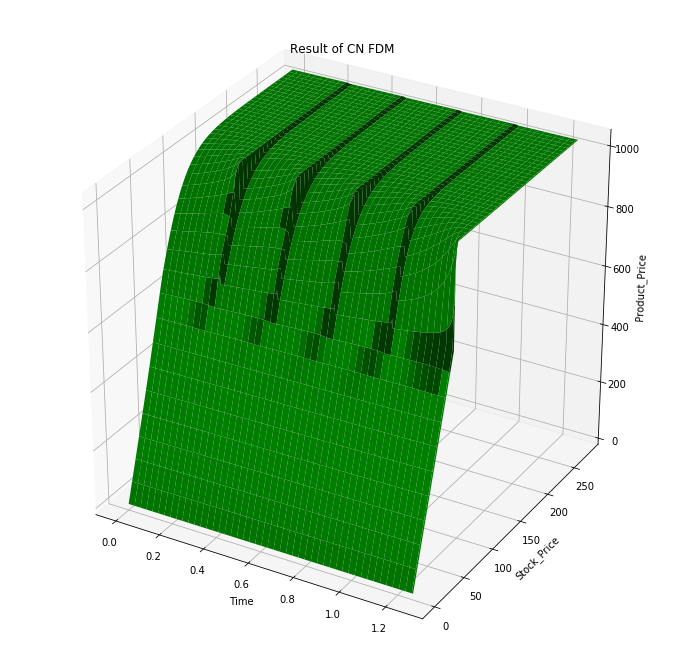

In [12]:
Security_Plot(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
              Coupon_date,S_max_times=3,S_min_times=0,F=1000,
              c_rate = 0.13,compound = 1/4,N=300, dt = 1/365)

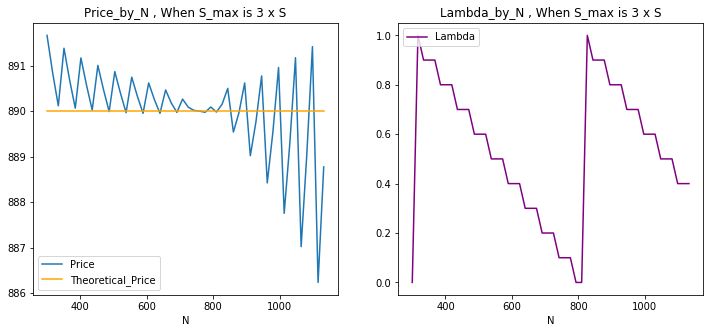

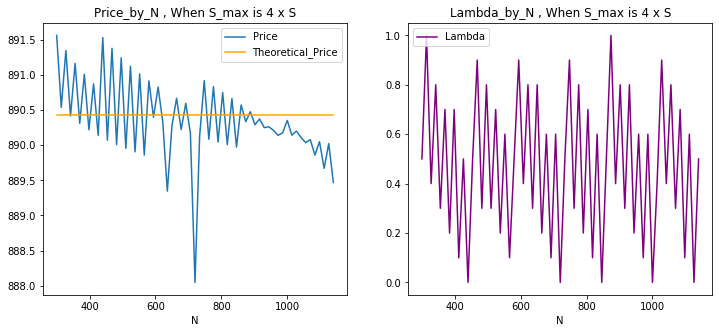

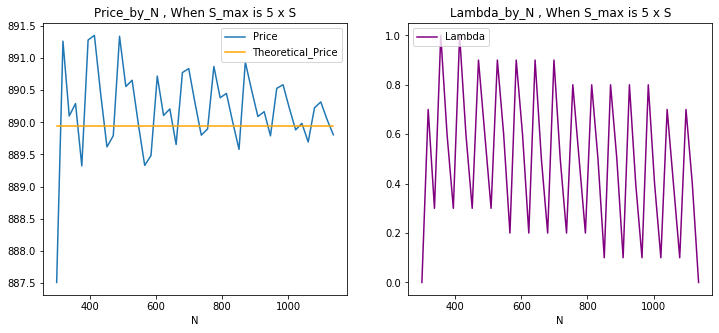

In [13]:
all_plotting()

In [11]:
def optimal_N(S_max_times = 3,Ntimes = 17) :
    P_lst = []
    lamb_lst = []
    for n in np.arange(300,1150,Ntimes):
        P, lamb = Current_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                                Coupon_date,S_max_times=S_max_times,S_min_times=0,F=1000,
                                c_rate = 0.13,compound = 1/4,N=n)
        P_lst.append(P)
        lamb_lst.append(lamb)
    
    Lamb_std_data = pd.DataFrame([P_lst,lamb_lst], index = ['Price','Lambda']).T.groupby('Lambda').std().rename(columns = {'Price' : 'PRICE_STD'})
    Lamb_mean_data = pd.DataFrame([P_lst,lamb_lst], index = ['Price','Lambda']).T.groupby('Lambda').mean().rename(columns = {'Price' : 'Mean_Price'})
    Optimal_Lamb = Lamb_std_data.iloc[np.array(Lamb_std_data.PRICE_STD).argmin()].name
    df = pd.DataFrame([P_lst,lamb_lst], index = ["price","Lambda"], columns = np.arange(300,1150,Ntimes)).T
    N_op = df[df['Lambda'] == Optimal_Lamb].Lambda.index[0]
    return N_op

In [12]:
N_op = optimal_N(S_max_times = 3,Ntimes = 17)

In [13]:
def Greeks(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,           
           Coupon_date, S_max_times=3, S_min_times=0,F=1000,
           c_rate = 0.13, compound = 1/4, N=300, dt = 1/365) :
    Price = Security_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                           Coupon_date,S_max_times,S_min_times,F,
                           c_rate,compound,N)

    S_max, S_min = S * S_max_times, S* S_min_times
    dS = (S_max - S_min)/N
    #########################
    #### Delta and Gamma ####
    ###################################################
    Delta = (Price.diff() / dS).round(6)
    Delta.iloc[0] = (2 * Delta.iloc[1] - Delta.iloc[2])
    Gamma = (Delta.diff()/ dS).round(6)
    Gamma.iloc[0] = (2* Gamma.iloc[1] - Gamma.iloc[2])
    ###################################################
    #### Vega(KI) , Vega(NKI) ####
    #########################################################################################
    dsigma_KI = sigma_KI * 0.01
    Price_prime_KI = Security_Price(S,K,B,sigma_KI + dsigma_KI,sigma_NKI,r,Div_S,today,Mat,
                                    Coupon_date,S_max_times,S_min_times,F,
                                    c_rate,compound,N)
    vega_KI = (Price_prime_KI - Price)/dsigma_KI

    dsigma_NKI = sigma_NKI * 0.01
    Price_prime_NKI = Security_Price(S,K,B,sigma_KI,sigma_NKI + dsigma_NKI,r,Div_S,today,Mat,                                     
                                     Coupon_date,S_max_times,S_min_times,F,
                                     c_rate,compound,N)
    vega_NKI = (Price_prime_NKI - Price)/dsigma_NKI
    #########################################################################################
    #### Sensitivity Interest ####
    ############################################################################
    dr = 0.01
    Price_prime_r = Security_Price(S,K,B,sigma_KI,sigma_NKI,r+dr,Div_S,today,Mat,                                   
                                   Coupon_date,S_max_times, S_min_times, F,
                                   c_rate,compound,N)
    ro = (Price_prime_r - Price)/dr
    ############################################################################        
    return Delta, Gamma , vega_KI,vega_NKI,ro

def Current_Greeks(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,                   
                   Coupon_date,S_max_times=3,S_min_times=0,F=1000,
                   c_rate = 0.13,compound = 1/4,N=300 ,dt = 1/365) :
    
    D, G ,V1,V2, ro= Greeks(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,                        
                        Coupon_date, S_max_times=S_max_times, S_min_times=S_min_times,F=F,                        
                        c_rate = c_rate, compound = compound, N=N, dt = dt)    
    
    if S in D.index :
        ind = list(D.index).index(S)
        Delta_today = D[today].iloc[ind]
        Gamma_today = G[today].iloc[ind]
        Vega1_today = V1[today].iloc[ind]
        Vega2_today = V2[today].iloc[ind]
        rho_today = ro[today].iloc[ind]
        return Delta_today, Gamma_today, Vega1_today,Vega2_today, rho_today
    else : 
        #######################################
        ####### Linear Interpolation    #######
        #######################################        
        ind = ((S - np.array(D.index))>=0).sum()
        x1 = D.index[ind-1]
        x2 = D.index[ind]
        y1_D = D[today].iloc[ind-1]
        y2_D = D[today].iloc[ind]
        y1_G = G[today].iloc[ind-1]
        y2_G = G[today].iloc[ind]
        y1_V1 = V1[today].iloc[ind-1]
        y2_V1 = V1[today].iloc[ind]
        y1_V2 = V2[today].iloc[ind-1]
        y2_V2 = V2[today].iloc[ind]
        y1_R = ro[today].iloc[ind-1]
        y2_R = ro[today].iloc[ind]
        
        slope_D = (y2_D-y1_D)/(x2-x1)
        slope_G = (y2_G-y1_G)/(x2-x1)
        slope_V1 = (y2_V1-y1_V1)/(x2-x1)
        slope_V2 = (y2_V2-y1_V2)/(x2-x1)
        slope_R = (y2_R-y1_R)/(x2-x1)

        Delta_today = slope_D*(S-x1)+y1_D    
        Gamma_today = slope_G*(S-x1)+y1_G    
        Vega1_today = slope_V1*(S-x1)+y1_V1
        Vega2_today = slope_V2*(S-x1)+y1_V2
        Rho_today = slope_R*(S-x1)+y1_R   
        
        return Delta_today, Gamma_today, Vega1_today, Vega2_today,Rho_today

In [14]:
Price_today = Current_Price(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,
                            Coupon_date,S_max_times=3,S_min_times=0,F=1000,                  
                            c_rate = 0.13,compound = 1/4,N=N_op )[0]

In [15]:
Delta_today, Gamma_today, Vega1_today, Vega2_today, Rho_today = Current_Greeks(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,                                                                               
                                                                               Coupon_date,S_max_times=3,S_min_times=0,F=1000,
                                                                               c_rate = 0.13,compound = 1/4,N=N_op ,dt = 1/365)


In [16]:
Data = pd.DataFrame([Price_today,Delta_today, Gamma_today, Vega1_today,Vega2_today, Rho_today] ,                    
                    index = ['Price','Delta','Gamma','Vega_KI','Vega_NKI','Rho'],
                    columns = ['Price_When_N_is'+str(N_op)])

In [20]:
Data.T

,Price,Delta,Gamma,Vega_KI,Vega_NKI,Rho
Price_When_N_is742,890.014821,5.802046,1.15185,-73.940792,-232.621205,-140.183093


In [18]:
D,G,V1,V2,ro = Greeks(S,K,B,sigma_KI,sigma_NKI,r,Div_S,today,Mat,                      
                      Coupon_date, S_max_times=3, S_min_times=0,F=1000,
                      c_rate = 0.13, compound = 1/4, N=N_op, dt = 1/365)

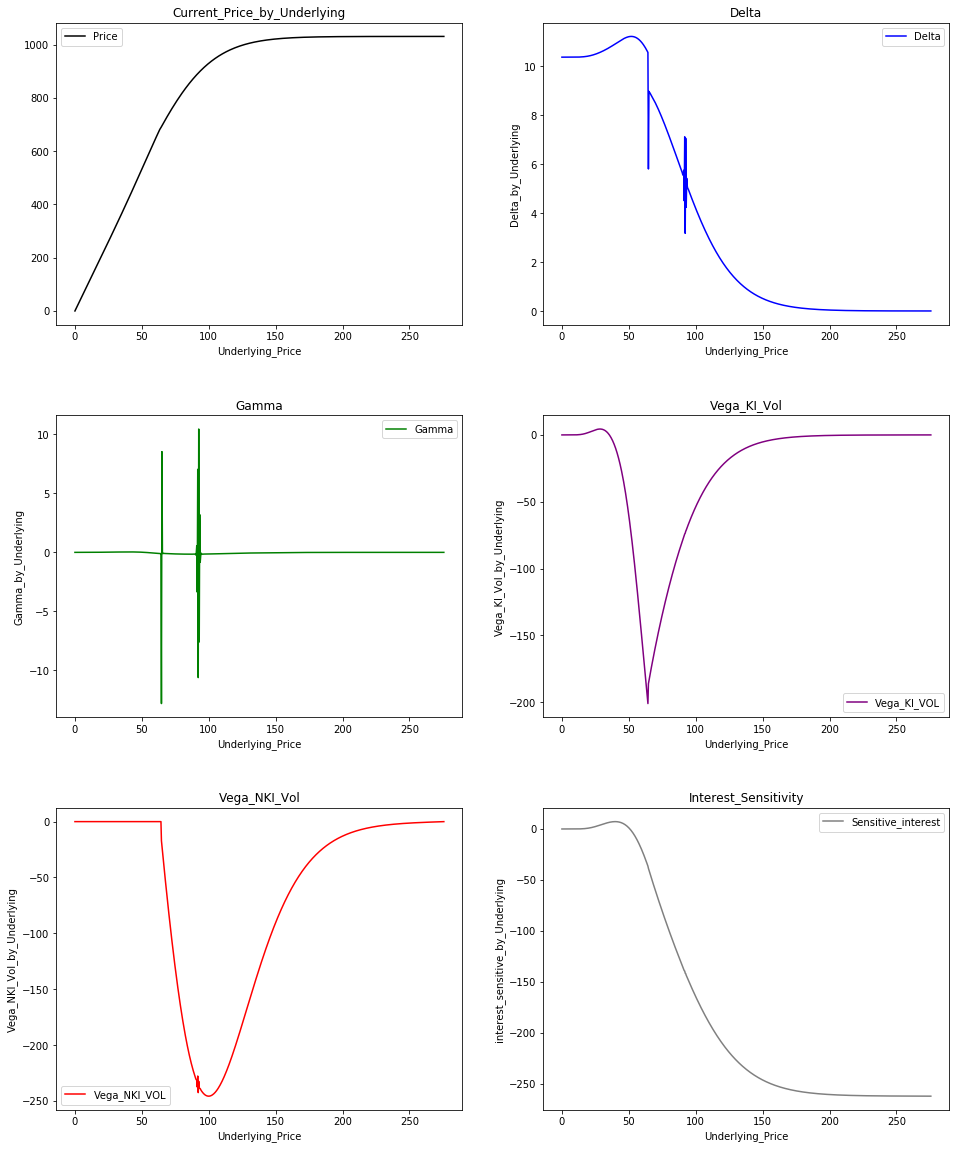

In [19]:
plt.figure(figsize=(16,20))
plt.subplot(3,2,1)
plt.plot(Price[Price.columns[0]], label = 'Price', color = 'black')
plt.legend(loc = 'best')
plt.xlabel('Underlying_Price')
plt.subplots_adjust(wspace = 0.2 , hspace = 0.3 )
plt.title('Current_Price_by_Underlying')

plt.subplot(3,2,2)
plt.plot(D[D.columns[0]] , label = 'Delta', color = 'blue')
plt.legend(loc = 'best')
plt.ylabel('Delta_by_Underlying')
plt.xlabel('Underlying_Price')
plt.title('Delta')

plt.subplot(3,2,3)
plt.plot(G[G.columns[0]], label = 'Gamma', color = 'Green')
plt.legend(loc = 'best')
plt.ylabel('Gamma_by_Underlying')
plt.xlabel('Underlying_Price')
plt.title('Gamma')

plt.subplot(3,2,4)
plt.plot(V1[V1.columns[0]], label = 'Vega_KI_VOL', color = 'Purple')
plt.legend(loc = 'best')
plt.ylabel('Vega_KI_Vol_by_Underlying')
plt.xlabel('Underlying_Price')
plt.title('Vega_KI_Vol')

plt.subplot(3,2,5)
plt.plot(V2[V2.columns[0]], label = 'Vega_NKI_VOL', color = 'Red')
plt.legend(loc = 'best')
plt.ylabel('Vega_NKI_Vol_by_Underlying')
plt.xlabel('Underlying_Price')
plt.title('Vega_NKI_Vol')


plt.subplot(3,2,6)
plt.plot(ro[ro.columns[0]], label = 'Sensitive_interest', color = 'gray')
plt.legend(loc = 'best')
plt.ylabel('interest_sensitive_by_Underlying')
plt.xlabel('Underlying_Price')
plt.title('Interest_Sensitivity')
plt.show()


In [21]:
G[G.columns[0]].iloc[125:400].mean(),V1[V1.columns[0]].iloc[125:400].mean(),V2[V2.columns[0]].iloc[125:400].mean(), ro[ro.columns[0]].iloc[125:400].mean()

(-0.10342836363636364,
 -68.76122876103787,
 -144.36094410805907,
 -140.00414546679764)